<a href="https://colab.research.google.com/github/ozcanmiraay/Buenos-Aires-Lands-Regression-Analysis/blob/main/Computational_Bayesian_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Linear regression and model comparison

All the analyses and code in this workbook are uniquely produced by Miray Ozcan.

## Fitting models to the 'Lands of Buenos Aires: Prices' dataset

## Part 1: Data

### Background

Buenos Aires, the vibrant capital of Argentina, has recently faced a tumultuous period marked by rampant inflation, significant devaluation of the national currency Argentine peso, and a consequential strain on housing affordability and accessibility. The city's inflation rates have skyrocketed recently, resulting in pressing socio-economic challenges such as rising homelessness. In 2018, almost a million of the city's inhabitants rented homes, navigating the complexities of unpredictable and often speculative pricing. Additionally, the stark contrast in the availability of homes for sale versus those for rent underscores a pronounced real estate disparity. This dissonance has also manifested in unsettling scenes where public spaces, like the Jorge Newbery International Airport, have transformed into makeshift shelters for people experiencing homelessness.

Given the intricacy and urgency of these housing issues, it becomes imperative to delve deeper into the land and property trends that underpin them. To this end, the 'Lands of Buenos Aires: Prices' dataset we analyze in this report provides an invaluable resource. Originally sourced from the Buenos Aires Data program, this dataset offers a comprehensive look into the evolving land prices in the city, allowing for a meticulous analysis of the root causes and potential solutions to Buenos Aires' housing predicament.

### Variables and Focused Segment of the Dataset

The dataset includes the City of Buenos Aires's land property information from 2014-2018 across 15 districts and 48 neighborhoods. Over 7000 observed data points representing land properties are included in the dataset with specified characteristics of geographic location, land area, price, community, etc. Particularly, the following variables characterize the observations in the dataset:

1. **LAT:** latitude
2. **LON:** longitude
3. **M2:** total area in square meters
4. **USD:** price in USD
5. **NEIGHBORHOOD:** neighborhood
6. **COMMUNE:** district, community

In this report, we will define the **M2**, total area of the land property in square meters, as the **predictor (x)** variable, and the **USD**, price of the land property in USD, as the **response (y)** variable. We will fit different models to the observed data points based on these variables to study their relationship.  

Further, we will focus our analyses on the land properties in a pre-defined segment of the City of Buenos Aires, specifically **Flores and Floresta neighborhoods**. There are two main reasons we are focusing on these neighborhoods:

1. The prices of the land properties tend to be confounded by location-based factors, and by restricting the dataset to two geographically close neighborhoods, we strive to control for this confounding variable.
2. Through a quick exploratory analysis of the dataset, we realize that Flores and Floresta neighborhoods have the most observed data points combined (546), as well as being neighboring neighborhoods. Our choice is justified by our desire to include as many data points as possible to reach more robust conclusions.

#### Map of Flores, City of Buenos Aires, Argentina

![BA_Flores.png](attachment:BA_Flores.png)

#### Map of Floresta, City of Buenos Aires, Argentina

![BA_Floresta.png](attachment:BA_Floresta.png)

### Data Source

#### Original Dataset - Accessed Through Kaggle

Lands of Buenos Aires: prices. (2019). [Dataset]. In Kaggle. https://www.kaggle.com/datasets/epassaro/lands-of-buenos-aires-prices

Buenos Aires Data | Terrenos: Valor de Oferta. (n.d.). [Dataset]. In Buenos Aires Data. https://data.buenosaires.gob.ar/dataset/terrenos-valor-oferta

#### Focused Dataset - Flores and Floresta Neighborhoods (Import This Dataset to Reproduce This Report)

ba_data_flores_floresta_2014_2018. (n.d.). [Dataset]. In Google Docs. https://docs.google.com/spreadsheets/d/1NV_TV8QY54cnKkiUi7gL5LaUBABZCMPHp3bv2e1d5vk/edit#gid=0

### Importing the Data and Libraries

In [ ]:
# This cell is needed to patch some out-of-date libraries on Jupyter Notebook.

print('Upgrading PyMC to version 5. This takes about 50 seconds...')
!pip install --ignore-installed llvmlite > /dev/null 2> /dev/null
!pip install --upgrade "pymc>=5,<6" numexpr matplotlib numba > /dev/null 2> /dev/null

import pymc as pm
print(f"We're running PyMC v{pm.__version__} today.")

Upgrading PyMC to version 5. This takes about 50 seconds...
We're running PyMC v5.6.1 today.


In [ ]:
# Import necessary libraries

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import pytensor.tensor as pt

In [ ]:
#Set the default credible interval used by arviz

az.rcParams["stats.hdi_prob"] = 0.95

In [ ]:
# Import the data

data = pd.read_csv(
    "ba_data_flores_floresta_2014_2018.csv", header=0)

# Show the first few observed data points

print(f'There are {len(data)} observed data points in the dataset.')
data.head()

There are 546 observed data points in the dataset.


,LAT,LON,M2,USD,NEIGHBORHOOD,COMMUNE,YEAR
0,-58.452444,-34.643508,110,69900,FLORES,7,2014
1,-58.458876,-34.648287,200,80000,FLORES,7,2014
2,-58.464511,-34.639267,260,129000,FLORES,7,2014
3,-58.464027,-34.638082,229,130000,FLORES,7,2014
4,-58.462488,-34.618331,147,180000,FLORES,7,2014


In [ ]:
# Check if there is any row with missing values for the predictor and response variables

has_missing_values = data[['USD', 'M2']].isnull().any().any()
print('Missing values for M2 and USD variables?:', has_missing_values)

# Drop missing values if there is any

final_data = data.dropna(subset=['USD', 'M2'])
print(f"Number of rows with non-missing values for M2 and USD variables: {len(final_data)}")

Missing values for M2 and USD variables?: False
Number of rows with non-missing values: 546


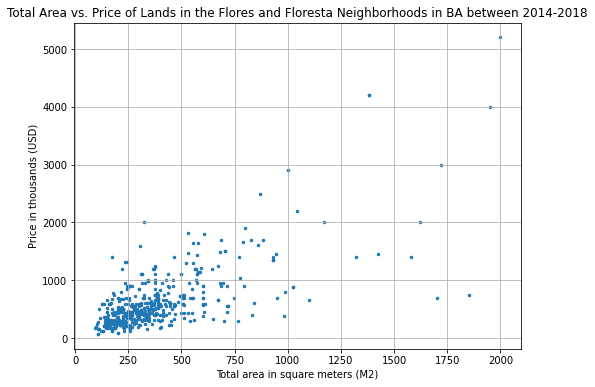

In [ ]:
# Define the predictor and response variables to be used throughout the assignment

# Land Use of House, measured in squared meters
land_data = final_data['M2']

# Price of House, measured in USDs
price_data = final_data['USD'] / 1000 # Divide price values by 1000 for better visualization purposes

# Plot the data

plt.figure(figsize=(8, 6))
plt.scatter(land_data, price_data, s=6)
plt.xlabel('Total area in square meters (M2)')
plt.ylabel('Price in thousands (USD)')
plt.title('Total Area vs. Price of Lands in the Flores and Floresta Neighborhoods in BA between 2014-2018')
plt.grid(True)
plt.show()

## Part 2: Models

### Normal Likelihood Model

#### Model Description

In a Normal likelihood model for linear regression, the observed data is assumed to follow a Normal distribution around a linear combination of predictor variables. This model suggests that the discrepancies between the observed values and those that the linear regression predicted had a Normal distribution.

In our Normal likelihood model, we need to select priors for the intercept, which we call **c0**, the coefficient of the x values in the mean equation of the likelihood function, which we call **c1**, and the standard deviation of the likelihood function, which we call **sigma**. For this model, our priors for **c0** and **sigma** follow Uniform distributions, while **c1** follows a Normal distribution.

\begin{align*}
p_i &\sim \text{Normal}(\mu_i, \sigma) & \text{[likelihood]} \\
\mu_i &= \ c_1 + \ c_0x_i & \text{[linear model]} \\
\ c_0 &\sim \text{Uniform}(0, 100) & \text{[$\ c_0$ prior]} \\
\ c_1 &\sim \text{Normal}(0, 10^2) & \text{[$\ c_1$ prior]} \\
\sigma &\sim \text{Uniform}(0, 100) & \text{[$\sigma$ prior]}
\end{align*}

**Justifying c0 prior:** Since price data cannot contain negative values, we can only assume that the intercept would most likely be positive. Based on this intuition, we chose the Uniform distribution over the Normal distribution for **c0**. Unlike the Normal distribution, the Uniform distribution allows us to be ambiguous about the intercept and considers a broad range of values. However, it should be noted that our choice of Uniform distribution ignores the well-accepted fact that a property's price typically correlates with its land area. We acknowledge this trade-off to have a more impartial prior belief.

**Justifying c1 prior:** For the prior distribution of **c1**, the Normal distribution offers a more flexible representation than the Uniform distribution, especially for parameters like slopes where we might not want to constrain potential values arbitrarily.

We ensure neutrality by choosing a mean of 0 for the slope prior, thus not introducing any undue bias towards positive or negative slopes. This is particularly important in cases where prior knowledge does not provide clear evidence for a positive or negative relationship. Although we can intuitively estimate that land properties with more land area are usually more expensive, we don't want this potentially over-simplified intuition to influence our conclusions because there might be more significant factors that determine a property's price than its land area.

The chosen standard deviation of 10 further underscores this neutrality. While it allows for variation, it doesn't expect excessively steep slopes, capturing our belief that extreme slopes are possible but less likely. Therefore, the Normal distribution with the specified parameters offers a delicate balance: it doesn't restrict the slope to a fixed range, yet it anchors our expectations in a region that aligns with our understanding of the data's nature.

**Justifying sigma prior:** Firstly, the Uniform distribution we chose highlights our uncertainty. By using this non-informative prior, we can be sure that we aren't favoring any one value in the 0-100 range too soon. As with our explanation for selecting a Uniform prior for c0, this selection makes sense when we either have little prior information or want our model's predictions to be neutral. Additionally, we encourage flexibility in the model by placing the sigma boundaries between 0 and 100. This range is sufficiently broad to accommodate the outliers and capture the central data concentration.

The upper bound of 100 suggests we anticipate differences in our forecasts to be at most $100,000. This assumption seems reasonable given the scatter in our data and the usual land-area-based property price swings.

#### Python Implementation and Sampler Check

In [ ]:
# Normal likelihood model implementation, inspired by CS146 Session 8 PCW

with pm.Model() as normal_model:

    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=100)
    c1 = pm.Normal('c1', mu=0, sigma = 10)
    sigma = pm.Uniform('sigma', lower=0, upper=100)

    # Data
    x = pm.MutableData('x', land_data)
    y = pm.MutableData('y', price_data)

    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)

    # Likelihood
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    # Samples for data modeling
    samples_normal = pm.sample(1000, tune=1000)

    # Samples for model comparison
    normal_inference = pm.sample()
    pm.compute_log_likelihood(normal_inference)
    pm.sample_posterior_predictive(normal_inference, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,81.692,7.361,67.984,96.555,0.187,0.135,1471.0,1228.0,1.0
c1,1.408,0.016,1.377,1.439,0.000,0.000,1482.0,1618.0,1.0
sigma,99.985,0.015,99.955,100.000,0.000,0.000,1824.0,1364.0,1.0


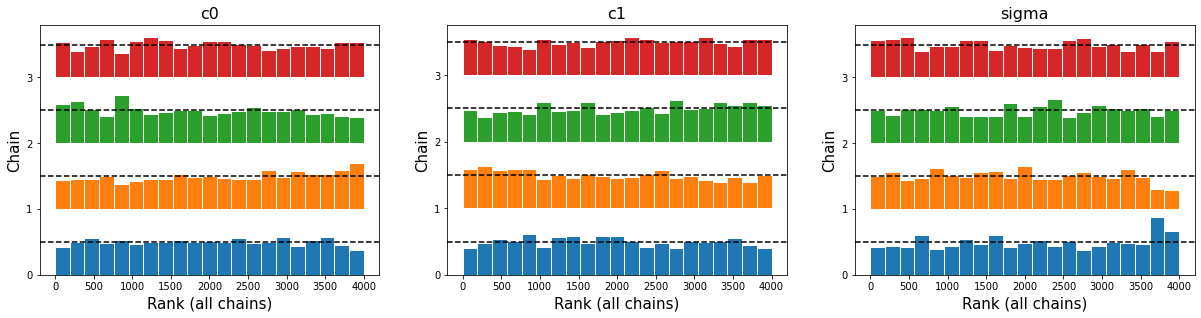

In [ ]:
# Use the sampler to sample from the defined normal model and ensure it works correctly

with normal_model:
    normal_inference_all = pm.sample()

# Display rank plots of 4 chains per distribution
az.plot_rank(normal_inference_all, var_names=['c0', 'c1', 'sigma'])

# Display summary statistics (Posterior)
az.summary(normal_inference_all, var_names=['c0', 'c1', 'sigma'])

We validate that our sampler works correctly, as seen from the posterior summary statistics table and the rank plots above.

The sampling summary statistics briefly explain what transpired in the Markov chains, which are chains of samples. The summary includes data demonstrating the effectiveness of the Markov chains and the posterior distributions for each model parameter. Thus, we want to discuss whether these statistics allow us to conclude that the Markov chains are excellent quality. We will concentrate on the "r_hat," "ess_tail," and "ess_bulk" variables in the preceding table to ascertain this.

**r_hat:** We want a r_hat value that is very close to 1. A value like 1.01 is okay, while 1.1 is undesirably large. Since the r_hat values for all the parameters under our focus are 1.0, we conclude our sampling algorithm works well from this aspect.

**ESS columns:** These columns represent the effective sample size, meaning the part of the samples that are independent. We want both values for ess_bulk and ess_tail to be at least 10% of the total samples and as large as possible. Since our number of samples is 1000 with a tune value of 1000, and we are running the samples on 4 Markov chains, we want the ESS columns to show at least 800. Since the ess_bulk and ess_tail values in our summary statistics table show considerably more than this minimum threshold, our sampling algorithm should work well.

Every chain in the sampler and every unobserved variable in the model has a histogram displayed in a rank plot. Using rank charts, we may assess the accuracy with which our sampler searches the whole posterior distribution. Each sampling process starts at a different, random position. If we take all the samples (from all chains) for a particular variable, sort them, and then histogram the rank (the sorted index/location of the values), we should receive a uniform distribution for each chain. There would be a sizable block of numbers from that chain in the sorted list and a peak on its histogram if one chain could not locate parts of the posterior that another chain could identify.

Upon examining the histograms produced by our sampling algorithm across four chains, we see that every sample largely conforms to a consistent, uniform distribution, with variations only marginally occurring above or below the dashed black lines. This pattern further demonstrates the accuracy of our sampling algorithm.

#### Displaying Credible Intervals and Interpretation

Sampling: [likelihood]


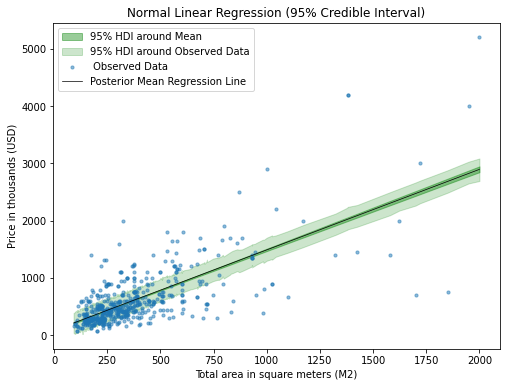

In [ ]:
# Display the posterior predictive credible intervals, inspired by CS146 Session 7 PCW and Session 8 PCW

# Extract the 'mu' values from the posterior samples to use for predictions
mu_normal_pred = samples_normal.posterior["mu"]

# Thin the samples by taking every 5th sample to reduce autocorrelation and computational load
samples_normal_thinned = samples_normal.sel(draw=slice(None, None, 5))

# Using the thinned samples, generate posterior predictive samples from the Normal likelihood model
with normal_model:
    normal_model_pred = pm.sample_posterior_predictive(samples_normal_thinned)


# Start plotting the results
plt.figure(figsize=(8, 6))

# Plot 95% High Density Interval (HDI) for the mean regression line
ax = az.plot_hdi(land_data, mu_normal_pred, color='green', smooth=False, fill_kwargs={"alpha": .4, 'label': '95% HDI around Mean'})

# Plot 95% HDI around the observed data
az.plot_hdi(land_data, normal_model_pred.posterior_predictive["likelihood"], ax=ax, color = 'green', smooth=False, fill_kwargs={"alpha": .2, 'label': '95% HDI around Observed Data'})

# Scatter plot of the observed data
plt.scatter(land_data, price_data, s = 10, alpha=0.5, label = ' Observed Data')

# Compute the posterior mean of the regression line
land_values_n = np.linspace(land_data.min(), land_data.max(), 200)
price_values_mean_n = (
    samples_normal.posterior["c0"].values.mean(axis=(0, 1))
    + samples_normal.posterior["c1"].values.mean(axis=(0, 1)) * land_values_n
)

# Plot the posterior mean regression line
plt.plot(land_values_n, price_values_mean_n, color='black', linewidth = 0.7, label="Posterior Mean Regression Line")

# Adding labels and title to the figure
plt.title('Normal Linear Regression (95% Credible Interval)')
plt.xlabel('Total area in square meters (M2)')
plt.ylabel('Price in thousands (USD)')
plt.legend()

# Display the final plot
plt.show()

In the Normal linear regression plot above, we can observe the posterior mean regression line and 95% high-density intervals (HDIs) around the mean and observed data. The 95% HDI around the mean (dark green area) displays our certainty level around the slope of the posterior linear regression equation, representing the relationship between our predictor and response variables. The 95% HDI around the observed data (light green) displays our certainty level for the location of the data points estimated through the posterior predictive distribution.

Let's interpret the 95% HDIs further. The dark green area represents that given the observed data and our Bayesian model, the actual mean regression line lies within this shaded region with 95% probability. It gives us an idea of where we believe the "average" predicted price lies for a given land area based on our posterior distribution.

The light green area is broader because it accounts for the uncertainty in the mean regression and noise in the observed data. Essentially, this interval tells us where we expect to observe a new data point for a given land area with 95% probability. It gives an idea of the range of prices we expect to see for properties of a given size, considering both the uncertainty in our model and the inherent variability in the data.

Looking at the 95% HDI around the observed data and how it doesn't encapsulate a significant amount of actual data points in the model, we start to hint that the Normal model may not be the best one to fit our data.

### Student T Likelihood Model

#### Model Description

In the Normal likelihood model, most data points outside the 95% HDI for the observed data were regarded as outliers. Compared to the conventional Normal distribution, the Student T linear regression model provides a better way to manage outliers. Because of its light tail, the Normal distribution may not effectively handle outliers when utilized as a likelihood function. A heavy-tailed distribution, like the Student T (or T distribution), can be used to address this, making the regression more robust. The T distribution introduces a parameter, ν (nu), which determines the tail's weight. A larger ν leads to lighter tails, similar to the Normal distribution. Specifically:

- For ν=1, the distribution has very heavy tails, implying a high chances of observing outliers.
- As ν approaches 30, the T distribution closely resembles the Normal distribution.
- When ν tends to infinity, the T distribution becomes the Normal distribution.

In our Student T likelihood model, we need to select priors for all the parameters we set a prior for in the Normal likelihood model. Additionally, we need a new prior for the tails' weight, which we call **nu**.

\begin{align*}
y_i &\sim T(\nu, \mu_i, \sigma) & \text{[likelihood]}\\
\mu_i &= \ c_1 + \ c_0x_i & \text{[linear model]} \\
\ c_0 &\sim \text{Uniform}(0, 100) & \text{[$\ c_0$ prior]} \\
\ c_1 &\sim \text{Normal}(0, 10^2) & \text{[$\ c_1$ prior]} \\
\sigma &\sim \text{Uniform}(0, 100) & \text{[$\sigma$ prior]} \\
\nu &\sim \text{Half-Normal}(\sigma = 30) & \text{[$\nu$ prior]}
\end{align*}

**Justifying nu prior:** The selection of the prior for ν is influenced by the nature of the Student T distribution and its relationship with the Normal distribution. Opting for the positive half of a Normal distribution acknowledges the constraint that ν must be positive. Here, we strategically set the scale parameter to 30 to ensure that the prior encompasses values of ν, which makes the T distribution approximate the Normal distribution. This flexibility in the prior permits the model to account for data scenarios ranging from normal-like to those with heavier tails, addressing potential outliers.

All other prior distributions and parameters are the same as the Normal likelihood model, so their justifications also hold for the Student T likelihood model.

#### Python Implementation and Sampler Check

In [ ]:
# Student T likelihood model implementation, inspired by CS146 Session 8 PCW

with pm.Model() as t_model:

    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=100)
    c1 = pm.Normal('c1', mu=0, sigma = 10)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    nu = pm.HalfNormal('nu', sigma=30)

    # Data
    x = pm.MutableData('x', land_data)
    y = pm.MutableData('y', price_data)

    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)

    # Likelihood
    pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)

    # Samples for data modeling
    samples_t = pm.sample(1000, tune=1000)

    # Samples for model comparison
    t_inference = pm.sample()
    pm.compute_log_likelihood(t_inference)
    pm.sample_posterior_predictive(t_inference, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,76.995,12.572,54.732,99.968,0.319,0.229,1432.0,1043.0,1.0
c1,1.184,0.043,1.104,1.272,0.001,0.001,1626.0,2002.0,1.0
sigma,98.672,1.251,96.197,99.999,0.022,0.016,1961.0,1331.0,1.0
nu,1.156,0.079,1.012,1.324,0.002,0.001,2280.0,2032.0,1.0


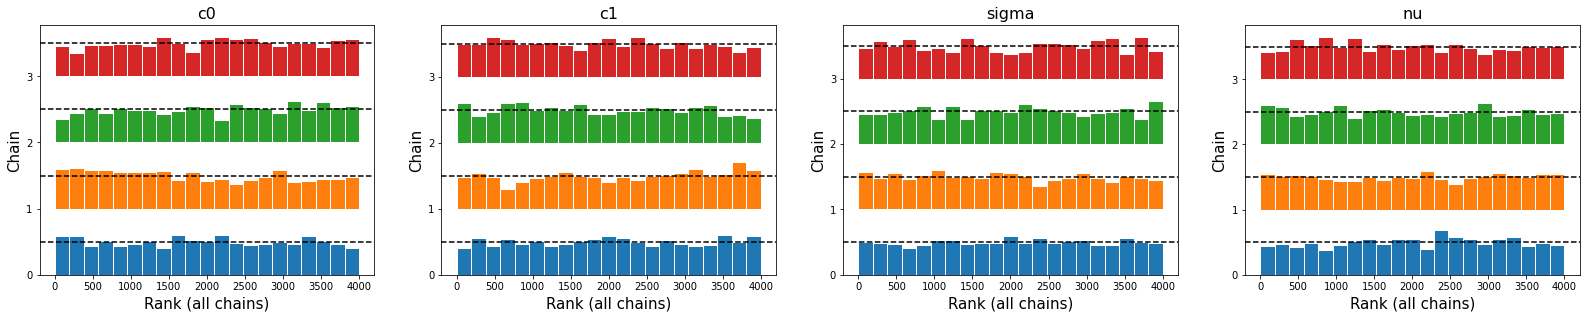

In [ ]:
with t_model:
    t_inference_all = pm.sample()

# Display rank plots of 4 chains per distribution
az.plot_rank(t_inference_all, var_names=['c0', 'c1', 'sigma', 'nu'])

# Display summary statistics (Posterior)
az.summary(t_inference_all, var_names=['c0', 'c1', 'sigma', 'nu'])

Drawing from our explanations in the Normal likelihood model, we conclude that our sampler for the Student-T likelihood model also works as expected. Specifically, we come to this conclusion by observing r_hat values at 1.0, ESS values greater than 10% of the number of samples, and uniformity in the distribution of samples in the rank plots across all four Markov chains and parameters.

#### Displaying Credible Intervals and Interpretation

Sampling: [likelihood]


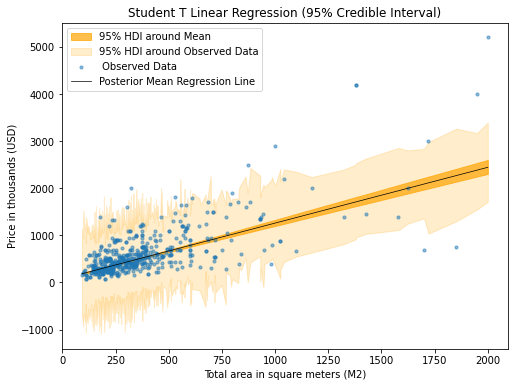

In [ ]:
# Display the posterior predictive credible intervals, inspired by CS146 Session 7 PCW and Session 8 PCW

# Extract posterior samples for mu from the trained model
mu_t_pred = samples_t.posterior["mu"]

# Thin out the samples to reduce computation (select every 5th sample)
samples_t_thinned = samples_t.sel(draw=slice(None, None, 5))

# Using the thinned-out samples, generate posterior predictive samples from the Student-T model
with t_model:
    t_model_pred = pm.sample_posterior_predictive(samples_t_thinned)


# Initialize a figure with a specific size
plt.figure(figsize=(8, 6))

# Plot the 95% High Density Interval (HDI) for the mean regression line using ArviZ's plot_hdi function
ax = az.plot_hdi(land_data, mu_t_pred, color='orange', smooth=False, fill_kwargs={"alpha": .7, 'label': '95% HDI around Mean'})

# Plot the 95% HDI for the observed data
az.plot_hdi(land_data, t_model_pred.posterior_predictive["likelihood"], ax=ax, color = 'orange', smooth=False, fill_kwargs={"alpha": .2, 'label': '95% HDI around Observed Data'})

# Scatter plot the actual observed data
plt.scatter(land_data, price_data, s = 10, alpha=0.5, label = ' Observed Data')

# Compute the posterior mean of the regression line
land_values_t = np.linspace(land_data.min(), land_data.max(), 200)
price_values_mean_t = (
    samples_t.posterior["c0"].values.mean(axis=(0, 1))
    + samples_t.posterior["c1"].values.mean(axis=(0, 1)) * land_values_t
)

# Plot the mean regression line using the posterior samples
plt.plot(land_values_t, price_values_mean_t, color='black', linewidth = 0.7, label="Posterior Mean Regression Line")

# Add labels and title to the figure for clarity
plt.title('Student T Linear Regression (95% Credible Interval)')
plt.xlabel('Total area in square meters (M2)')
plt.ylabel('Price in thousands (USD)')

# Show the legend to help interpret the plots
plt.legend()

# Display the plotted figure
plt.show()

The Student T linear regression figure above displays the posterior mean regression line and 95% high-density intervals (HDIs) surrounding the mean and observed data. Our degree of certainty in the slope of the posterior linear regression equation, which illustrates the relationship between our predictor and response variables, is shown by the 95% HDI around the mean (dark orange area). Our degree of certainty regarding the position of the data points projected using the posterior predictive distribution is shown by the 95% HDI surrounding the observed data (light orange).

When interpreting these HDIs further, the dark orange area indicates that, with 95% probability, the actual mean regression line resides inside this shaded region based on the observed data and our Bayesian model. Using our posterior distribution, it offers us an estimate of the "average" expected price for a specific land area region.

Because it considers the noise in the observed data and the uncertainty in the mean regression, the light orange area is larger. With a 95% probability, this interval tells us where to anticipate finding a new data point for a specific land area region. Considering both the intrinsic variability in the data and the uncertainty in our model, it provides a sense of the range of prices we expect to see for properties of a specific size.

Visually, the Student T model fits our data well based on the 95% HDI surrounding the observed data and how it encompasses many observed data points in the model.

### Contrasting Normal and Student T Likelihood Models

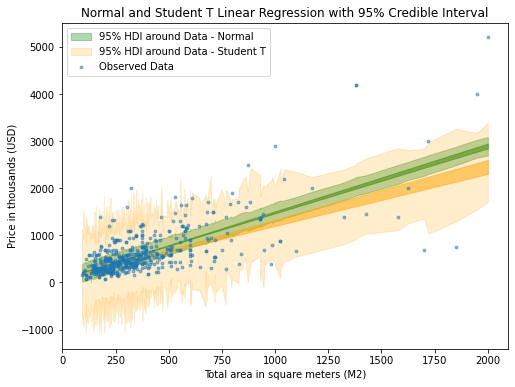

In [ ]:
# Plot the posterior 95% HDIs for Normal and Student T models, inspired by CS146 Session 7 PCW and Session 8 PCW

# Initialize a figure with a specific size
plt.figure(figsize=(8, 6))

# Add title and axis labels to the plot for clarity
plt.title('Normal and Student T Linear Regression with 95% Credible Interval')
plt.xlabel('Total area in square meters (M2)')
plt.ylabel('Price in thousands (USD)')

# Plot the 95% High Density Interval (HDI) for the mean regression line of the Normal model using ArviZ's plot_hdi function
ax = az.plot_hdi(land_data, mu_normal_pred, color='green', smooth=False)

# Plot the 95% HDI for the observed data for the Normal model
az.plot_hdi(land_data, normal_model_pred.posterior_predictive["likelihood"], ax=ax, color = 'green', smooth=False, fill_kwargs={"alpha": .3, 'label': '95% HDI around Data - Normal'})

# Plot the 95% HDI for the mean regression line of the Student T model
ax = az.plot_hdi(land_data, mu_t_pred, color='orange', smooth=False)

# Plot the 95% HDI for the observed data for the Student T model
az.plot_hdi(land_data, t_model_pred.posterior_predictive["likelihood"], ax=ax, color='orange', smooth=False, fill_kwargs={"alpha": .2, 'label': '95% HDI around Data - Student T'})

# Scatter plot the actual observed data
plt.scatter(land_data, price_data, s=8, alpha=0.5, label = 'Observed Data')

# Display the plotted figure
plt.legend()
plt.show()

Both models in the dense cluster region seem to fit the data relatively well (particularly in the range of 0-750 for 'Total area'). However, as the widening HDIs show, there is more significant uncertainty with bigger values of 'Total area.'

As we see from the comparison of the two models and how their posterior predictive 95% HDI around the observed data display, the Student T model is broader than that of the Normal model, suggesting that the Student T model accounts for more variability or uncertainty in the data than the Normal model. This makes sense, as the Student T distribution is more robust to outliers, and the wider interval could reflect that.

Based on our visual analysis, the Student T likelihood model may better fit our observed data than the Normal likelihood model, as the former includes more of the observed data points in its lighter-shaded area. However, we should take our time with this conclusion, as we will perform statistical analysis to test this hypothesis in the later sections of this report.

### Outlier Classifier Model

#### Model Description

The outlier classifier model moves beyond the blanket assumptions of our previous two models. Instead of classifying all data points under a singular distribution (light-tailed Normal or heavy-tailed Student T), this model acknowledges that a data set can have a mix of typical values and outliers.

In the Outlier Classifier model, each data point is tagged with a binary variable: '1' denotes an outlier, while '0' signifies a standard data point. This binary distinction arises from a Bernoulli distribution with an unknown probability parameter 'p_p,' which the model infers from the data. The likelihood formation aligns with the Normal model; however, it accommodates the possibility of different variances for different data points, indicated by the sigma subscript 'i'. This approach allows for a nuanced understanding of the data, recognizing regular patterns and deviations.

\begin{align*}
p_i &\sim \text{Normal}(\mu_i, \sigma_i) \\
\mu_i &= c_0 + c_1 x_i \\
\sigma_i &=
\begin{cases}
\sigma_{\text{in}} & \text{if } q_i = 0 \\
\sigma_{\text{in}} + \sigma_{\text{out}} & \text{if } q_i = 1
\end{cases} \\
q_i &\sim \text{Bernoulli}(p)
\end{align*}

\begin{align*}
c_0 &\sim \text{Uniform}(0, 100) \\
c_1 &\sim \text{Normal}(0, 10^2) \\
\sigma_{\text{in}} &\sim \text{Uniform}(0, 100) \\
\sigma_{\text{out}} &\sim \text{Half-Normal}(0, 30^2) \\
p_p &\sim \text{Uniform}(0, \frac{1}{2})
\end{align*}

In addition to using all the priors we have already set and justified for our Normal likelihood model, we define priors for **q, sigma_in, sigma_out,** and **p_p**.

**Justifying q prior:** Since we assigned q as an indicator variable, it is best represented by a Bernoulli distribution with a probability determined based on observed data, which returns 0 or 1 value.

**Justifying sigma_in prior:** All the justifications for the sigma prior in the Normal likelihood model section hold for this prior selection.

**Justifying sigma_out prior:** Here, we chose a Half-Normal distribution to get the positive half of a Normal distribution, as we know that standard deviation values cannot be zero. We selected a considerably high value for the scale of this distribution, 30, to demonstrate our lack of knowledge of the range of values that the standard deviation of the outliers' distribution can get.

**Justifying p_p prior:** Originally, this probability gets inferred from the data. However, here, we assume it is distributed uniformly between 0 and 0.5, a reasonable interval given that it represents a probability value.

#### Python Implementation and Sampler Check

In [ ]:
with pm.Model() as outlier_model:

    # Define observed data (land and price)
    x = pm.MutableData('x', land_data)
    y = pm.MutableData('y', price_data)

    # Define the priors for the linear regression intercept and slope
    c0 = pm.Uniform('c0', lower=0, upper=100)  # Intercept with a uniform prior between 0 and 100
    c1 = pm.Normal('c1', mu=0, sigma=10)       # Slope with a normal prior centered at 0 with std deviation of 10
    mu = pm.Deterministic('mu', c0 + c1 * x)   # Expected mean response for the linear regression

    # Define the noise parameters for both inliers and outliers
    sigma = pm.Uniform('sigma', lower=0, upper=100)  # Noise for inliers with uniform distribution
    sigma_out = pm.HalfNormal('sigma_out', sigma=30) # Noise for outliers with half-normal distribution
    sigmas = pt.as_tensor_variable([sigma, sigma + sigma_out]) # Concatenated noise parameters

    # Define the probability of a data point being an outlier and the corresponding indicator variable
    p = pm.Uniform('p', lower=0, upper=0.5)                # Probability a data point is an outlier
    is_outlier = pm.Bernoulli('is_outlier', p=p, size=x.shape[0]) # Indicator variable (1 for outlier, 0 for inlier)

    # Define the likelihood of the model given the observed data
    pm.Normal('likelihood', mu=mu, sigma=sigmas[is_outlier], observed=y)

    # Draw samples from the posterior distribution for data modeling
    samples_outlier = pm.sample(1000, tune=1000)

    # Additional samples and computations for model comparison
    outlier_inference = pm.sample()                         # Draw default samples
    pm.compute_log_likelihood(outlier_inference)            # Compute log likelihood
    pm.sample_posterior_predictive(outlier_inference, extend_inferencedata=True) # Posterior predictive sampling

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [c0, c1, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [c0, c1, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Sampling: [likelihood]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [c0, c1, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,41.752,15.542,12.058,71.529,0.489,0.346,991.0,1408.0,1.01
c1,1.339,0.048,1.252,1.438,0.002,0.001,766.0,1177.0,1.01
sigma,97.876,1.929,94.059,99.997,0.044,0.031,1634.0,1381.0,1.00
sigma_out,318.987,13.110,294.755,345.410,0.298,0.211,1933.0,2230.0,1.00
p,0.476,0.019,0.439,0.500,0.000,0.000,1205.0,1180.0,1.00


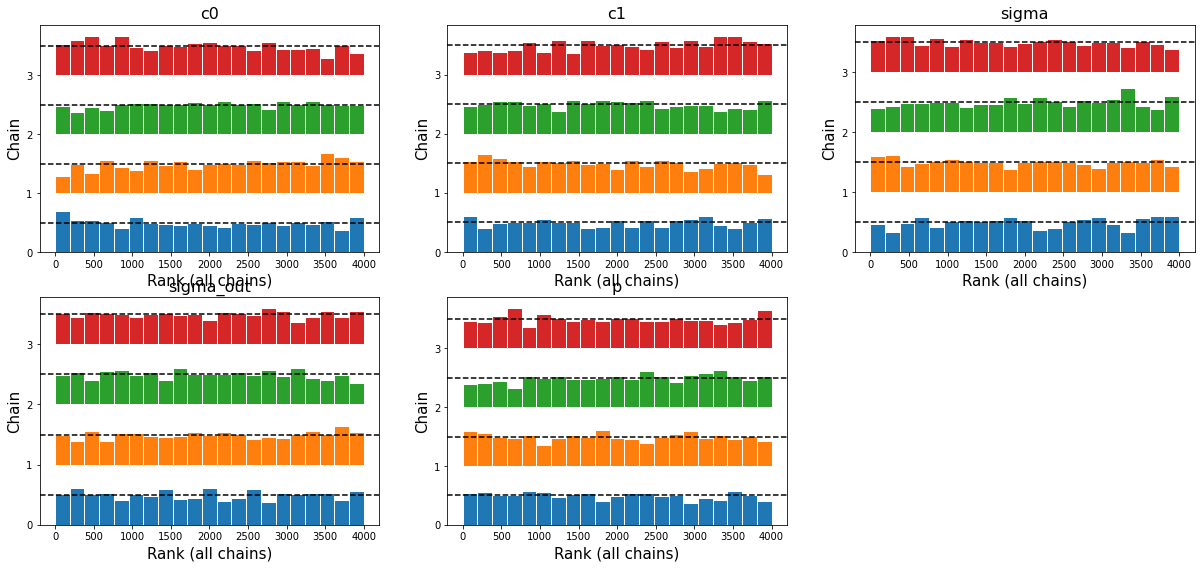

In [ ]:
with outlier_model:
    outlier_inference_all = pm.sample()

# Display rank plots of 4 chains per distribution
az.plot_rank(outlier_inference_all, var_names=['c0', 'c1', 'sigma', 'sigma_out', 'p'])

# Display summary statistics (Posterior)
az.summary(outlier_inference_all, var_names=['c0', 'c1', 'sigma', 'sigma_out', 'p'])

Our sampler for the Outlier Classifier likelihood model also performs as predicted, as covered in the previous two models. In particular, r_hat values at 1.0 or 1.01, ESS values more than 10% of the total number of samples, and uniformity in sample distribution across all four Markov chains and parameters in the rank plots lead us to this conclusion.

#### Visualization and Interpretation

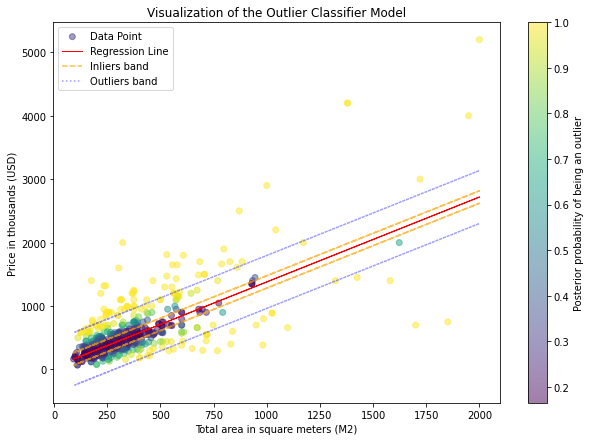

In [ ]:
# Visualize the Outlier Classifier Model, inspired by CS146 Session 8 PCW

# Extract posterior mean values for parameters
c0_mean = samples_outlier.posterior["c0"].values.mean(axis=(0, 1))
c1_mean = samples_outlier.posterior["c1"].values.mean(axis=(0, 1))
sigma_mean = samples_outlier.posterior["sigma"].values.mean(axis=(0, 1))
sigma_out_mean = samples_outlier.posterior["sigma_out"].values.mean(axis=(0, 1))

# Predicted values
predicted_values = c0_mean + c1_mean * land_data

# Calculate the upper and lower bounds for inliers and outliers
upper_inliers = predicted_values + sigma_mean
lower_inliers = predicted_values - sigma_mean
upper_outliers = predicted_values + sigma_mean + sigma_out_mean
lower_outliers = predicted_values - sigma_mean - sigma_out_mean

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(land_data, price_data, alpha=0.5, c=samples_outlier.posterior["is_outlier"].values.mean(axis=(0,1)), cmap='viridis', label='Data Point')
plt.plot(land_data, predicted_values, color='red', lw=1, label='Regression Line')

# Dashed lines for Inliers band
plt.plot(land_data, upper_inliers, '--', color='orange', alpha = 0.7, label='Inliers band')
plt.plot(land_data, lower_inliers, '--', color='orange', alpha = 0.7)

# Dotted lines for Outliers band
plt.plot(land_data, upper_outliers, ':', color='blue', alpha = 0.4, label='Outliers band')
plt.plot(land_data, lower_outliers, ':', color='blue', alpha = 0.4)

plt.colorbar().set_label('Posterior probability of being an outlier')
plt.xlabel('Total area in square meters (M2)')
plt.ylabel('Price in thousands (USD)')
plt.title('Visualization of the Outlier Classifier Model')
plt.legend()
plt.show()

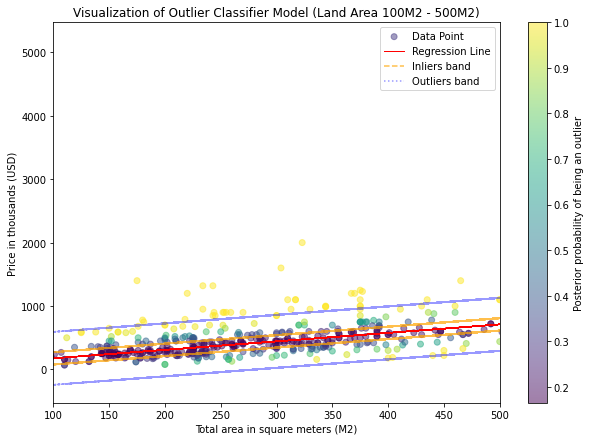

In [ ]:
# Look at land area values between 100M2 - 500M2

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(land_data, price_data, alpha=0.5, c=samples_outlier.posterior["is_outlier"].values.mean(axis=(0,1)), cmap='viridis', label='Data Point')
plt.plot(land_data, predicted_values, color='red', lw=1, label='Regression Line')

# Dashed lines for Inliers band
plt.plot(land_data, upper_inliers, '--', color='orange', alpha = 0.7, label='Inliers band')
plt.plot(land_data, lower_inliers, '--', color='orange', alpha = 0.7)

# Dotted lines for Outliers band
plt.plot(land_data, upper_outliers, ':', color='blue', alpha = 0.4, label='Outliers band')
plt.plot(land_data, lower_outliers, ':', color='blue', alpha = 0.4)

plt.colorbar().set_label('Posterior probability of being an outlier')
plt.xlabel('Total area in square meters (M2)')
plt.ylabel('Price in thousands (USD)')
plt.title('Visualization of Outlier Classifier Model (Land Area 100M2 - 500M2)')
plt.legend()
plt.xlim(100,500)
plt.show()

The Outlier Classifier model classifies the data points as outliers with a probability based on the color scale in the sidebar in the plot above. As we observe, the purple-blue colored data points are considered inliers, while the green-yellow colored data points are considered outliers. The yellow dashed inliers band shows the interval determined by going sigma_in deviations around the regression line on either side. The blue dotted outliers band shows the interval defined by going sigma_in + sigma_out deviations around the regression line on either side.

It is still possible to see specific data points within the inliers band that are actually outliers or a few data points outside the inliers band that may actually tend to be outliers. This observation is because we can think of outlier data points as distributed with a Normal distribution with standard deviation sigma_in + sigma_out and inlier data points as distributed with a Normal distribution with standard deviation sigma_in.

This model does a good job visually classifying data points with their degrees of being outliers and correctly identifying actual outliers as outliers, as observed by the entirely yellow data points outside of the outliers band. However, we need to perform a statistical analysis to see how this model does in comparison to the previous two models we studied.

## Part 3: Model Comparison

### Comparing Normal and Student T Likelihood Models

Now, we will quantify which model is the best to fit our data among the models we have described and implemented so far using the **PSIS-LOO-CV** (PSIS leave-one-out cross-validation) method.

Cross-validation is a technique that involves omitting portions of data from an observation and assessing the model on these omitted portions to evaluate a model's predictive performance on a different sample. The dataset is split into multiple "folds," and the model is trained on all except one before being tested on the excluded fold. Leaving-one-out cross-validation (LOOCV) is a widespread technique in which every observation is considered a separate fold, meaning the model is tested after training on all the other observations.

Although LOOCV is a reliable technique, it requires a lot of processing power. For example, constructing 1000 posterior distributions would be necessary for a dataset containing 1000 observations. But there is a way to get close to the cross-validation score without repeatedly running the model: by leveraging each observation's "importance" or effect on the posterior distribution. This "importance" concerns how much a particular observation's removal will alter the posterior distribution.

Pareto-smoothed importance sampling (PSIS) is an effective approximation technique for LOOCV. PSIS uses Pareto-smoothing, a method derived from the Pareto distribution, in conjunction with importance sampling, which uses the importance weights of the observations. By flagging observations with unduly high weights, PSIS gives feedback on the dependability of its cross-validation score, even in the absence of real cross-validation. Its pointwise format provides an approximative estimate of the standard error for out-of-sample deviation and is an additional advantage.

Below is the Python implementation of the PSIS-LOO-CV method on our Normal and Student T likelihood models.

/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student T,0,-3874.940448,3.910492,0.000000,1.0,33.377591,0.000000,False,log
Normal,1,-6667.544512,118.718079,2792.604064,0.0,560.259478,540.477121,True,log


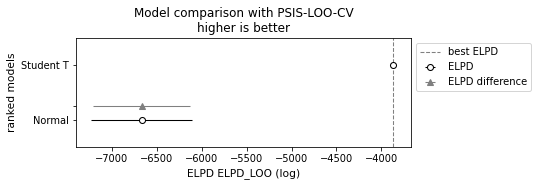

In [ ]:
# Inspired by Session 12 'Motorcycle Crash Data ' Workbook

# Define two models (normal and Student-T) for inference
inferences = {'Normal': normal_inference, 'Student T': t_inference}

# Use the compare function from ArviZ to compare the LOO (Leave-One-Out) values of the two models
df = az.compare(inferences, ic='loo')  # Compute and return a DataFrame containing LOO comparisons
display(df)  # Display the comparison DataFrame

# Visualize the model comparisons using a plot
az.plot_compare(df)  # Plot comparison of models using ArviZ function

# Add titles and labels to the plot for clarity
plt.title('Model comparison with PSIS-LOO-CV\nhigher is better')  # Title of the plot
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')            # x-axis label (ELPD stands for Expected Log Predictive Density)
plt.legend(['best ELPD', 'ELPD', 'ELPD difference'], loc='upper left', bbox_to_anchor=(1.0, 1.0)) # Legend to indicate different values on the plot

# Display the final plot
plt.show()

Let's clarify some of the terms in the results above, and use their values to guide our model comparison.

**rank:** Rankings are generated based on the models' out-of-sample prediction accuracy, with a lower rank representing a better performance. Therefore, the Student T model ranking of 0 is better than the Normal ranking of 1.

**elpd_loo:** ELPD stands for the "Expected Log Pointwise Predictive Density" based on LOOCV. Higher values represent better performance out-of-sample. This statistic also indicated that the Student T model is better than the Normal model.

**p_loo:** This value represents the effective number of parameters, meaning the number of parameters used to fit the data in the model. A smaller number represents simplicity in the model. More often than not, simple models are preferred over more complicated models due to their effectiveness and convenience in manipulation when needed. Student T has a smaller number of effective parameters, which further showcases its model effectiveness.

**elpd_diff:** ELPD difference represents the difference in ELPD between each comparison model and the top-ranked model. Therefore, the best model has a default value of 0 for this statistic, which is the Student T model in our case.

**weight:** The weight represents the probability of each model being the best for out-of-sample prediction. As Student T weighs 1.0, it is likely to be the better model in the system.

**se and dse:** These values show the standard error for estimating ELPDs. Since both values are higher for the Normal model, we are less likely to trust the ELPD value it generates.

The plot shows that the best ELPD crosses through the ELPD value for the Student T model. The ELPD value for the Normal model seems quite far from the best ELPD, represented by the dashed line. Further, the ELPD difference, meaning the difference between the lowest and the highest ELPD estimations for the Normal model, seems to have a high interval, still far from the best ELPD. In addition to the statistics analysis, the plot produced by the PSIS-LOO-CV method validates that Student T likelihood is a better model than Normal to fit our data.

### Comparing Normal, Student T, and Outlier Classifier Models

/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/mirayozcan/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Outlier Classifier,0,-3818.654993,118.374676,0.000000,8.688636e-01,39.699023,0.000000,True,log
Student-T,1,-3874.940448,3.910492,56.285455,1.311364e-01,33.377591,25.152731,False,log
Normal,2,-6667.544512,118.718079,2848.889519,5.521572e-11,560.259478,523.095377,True,log


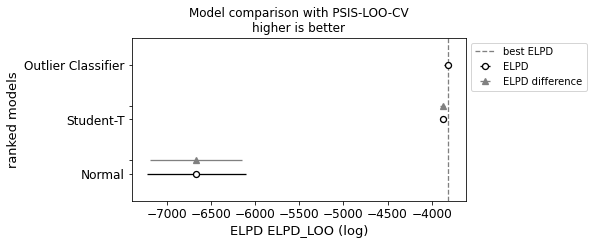

In [ ]:
# Inspired by Session 12 'Motorcycle Crash Data ' Workbook

# Define a dictionary to store three inference models: Normal, Student-T, and Outlier Classifier
inferences = {
    'Normal': normal_inference,          # Normal inference model
    'Student-T': t_inference,            # Student-T inference model
    'Outlier Classifier': outlier_inference  # Outlier classifier inference model
}

# Use the ArviZ library to compare the Leave-One-Out Cross Validation (LOO) values of the models
df = az.compare(inferences, ic='loo')  # Computes and compares LOO values, storing the result in a dataframe
display(df)  # Display the resulting comparison dataframe

# Generate a visual comparison of the models using ArviZ's plot_compare function
az.plot_compare(df)  # Creates a plot comparing the models based on their LOO values

# Customize the appearance of the comparison plot
plt.title('Model comparison with PSIS-LOO-CV\nhigher is better')  # Set the plot title
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')  # Label the x-axis based on the ELPD and the log transformation
plt.legend(['best ELPD', 'ELPD', 'ELPD difference'], loc='upper left', bbox_to_anchor=(1.0, 1.0))  # Add a legend to the plot

# Display the fully customized plot
plt.show()

We compare our Normal, Student T, and Outlier Classifier models in the outputs above. The statistics and the plots show that the Outlier Classifier has the highest rank, elpd_loo, and weight values. Further, the 0 value in the elpd_diff statistic showcases that the outcome has regarded this model as the "best" among all three.

However, we should also note that there is slightly more standard error attached to its computation of the ELPD value than the Student T, although this should not be a significant difference. Also, the fact that the effective parameter size for the Outlier Classifier model is significantly larger than the Student T model and almost equal to the effective parameter size value for the Normal model demonstrates that there is potentially a pay-off attached to the complicatedness of the Outlier Classifier model, although it is ranked the best.

Further, looking at the plot, we see that the ELPD value for the Outlier Classifier model crosses the best ELPD line, followed by the ELPD of the Student T model and its significantly narrow ELPD difference. The Normal model seems quite off from the other two models in terms of performance, demonstrated by its dispersed ELPD value and a broad ELPD difference interval.

As we discussed through the statistics and the plot, the Outlier Classifier seems to be the best model to fit our data and perform predictions out-of-sample. However, we should also note that the Student T model is quite close to the Outlier Classifier model in terms of performance and is less complicated. Therefore, in some instances where the resource pay-offs are considered, the Student T model could also be a reasonable choice to model our data.

## Use of AI Tools

I used AI tools like Grammarly and Quillbot to proofread and paraphrase some of the paragraphs I wanted to utilize from our pre-class workbooks from sessions 7 through 12 and the class textbook. I also used ChatGPT-4 for multiple purposes. Initially, I used its assistance in writing an introduction to justify the choice of my dataset by feeding it with three recent news articles I found online and asking it to summarize the information. Later, I used it to validate my intuition to justify some of the prior distributions I chose for my model parameters. Lastly, I asked it to add descriptive in-line comments to all the codes I have written to increase my codes' readability.

## References

- CS146 Session 7 Pre-Class Workbook
- CS146 Session 8 Pre-Class Workbook
- CS146 Session 12 Motorcycle Crash Workbook
- McElreath, R. (2015). Statistical Rethinking: A Bayesian Course with Examples in R and Stan. http://pubman.mpdl.mpg.de/pubman/item/escidoc:2183367
- Jazeera, A. (2023, April 7). Buenos Aires airport turns into unofficial homeless shelter. Housing News | Al Jazeera. https://www.aljazeera.com/news/2023/4/7/buenos-aires-airport-turns-into-unofficial-homeless-shelter
- Herald, B. A., & Herald, B. A. (2023, October 6). Buenos Aires City inflation reached record-breaking 12% in September. Buenos Aires Herald. https://buenosairesherald.com/economics/buenos-aires-city-inflation-reached-record-breaking-12-in-september
- Tome, J. (2021, November 30). Housing crisis in Argentina: the need for a broader perspective. Buenos Aires Times. https://www.batimes.com.ar/news/opinion-and-analysis/housing-crisis-in-argentina-the-necessity-to-address-the-problem-from-a-broader-perspective.phtml